In [8]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle
import time
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "3"
import torch
from torch.utils.data import DataLoader
from torch.nn import MSELoss

masked_cmap = matplotlib.cm.bwr
masked_cmap.set_bad('black', 0.5)

# import seaborn as sns
# sns.set(font_scale=1.4)
# sns.set_style("darkgrid")

# import models in ../scripts
import sys
sys.path.append("../scripts/")
from models import RandomFourierFeatureNetwork
from datasets import OOIDASDataset

from scipy.signal import butter, filtfilt
from scipy.signal import correlate

## load data

In [9]:
# DR_PATH = f"/fd1/yiyu_data/OOI/OOI-training-10min-demean-0-9-XMIN3000-XMAX15000.npz"
# TRAIN_DATA = np.load(DR_PATH)['raw'][::2, ::2]
# TRAIN_DATA -= TRAIN_DATA.min()
# TRAIN_DATA /= abs(TRAIN_DATA).max()

In [11]:
TRAIN_DATA = np.load('../datasets/OOI-training-10min-demean-normalize-0-9-XMIN3000-XMAX15000.npy')

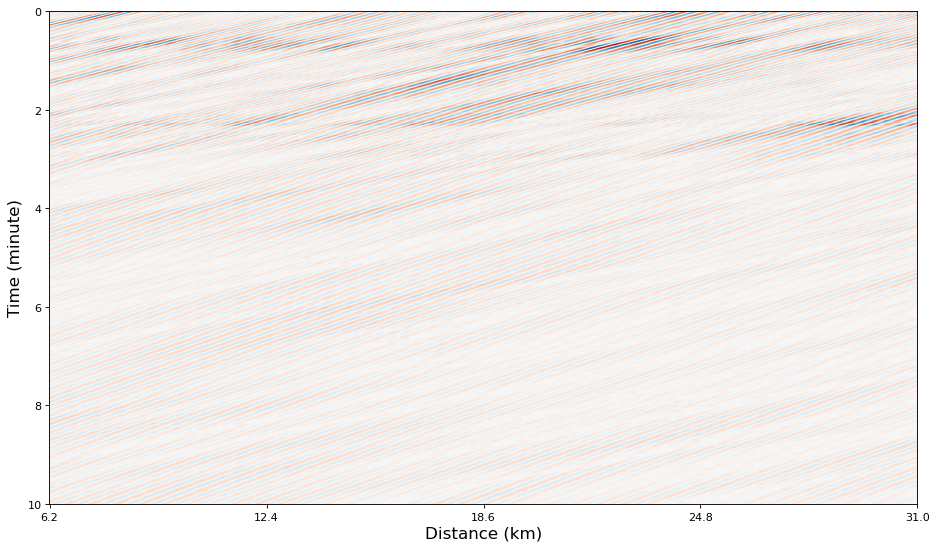

In [12]:
fig = plt.figure(figsize = (14, 8), dpi = 80)
plt.imshow(TRAIN_DATA, cmap = 'RdBu', aspect = 'auto', origin='upper')
# plt.title("Original", fontsize = 15)
plt.xlabel("Distance (km)", fontsize = 15)
plt.ylabel("Time (minute)", fontsize = 15)
# plt.colorbar()
plt.xticks(np.linspace(0, 6000, 5), ["%.1f"  % (int(i*5 + 3000)*2.07/1000) for i in np.linspace(0, 2400, 5)])
plt.yticks(np.linspace(0, 6000, 6), [int(i*50/200/60) for i in np.linspace(0, 2400, 6)])
plt.grid(False)

## preprocessing data and send to data loader

note that for the encoding/processing block, there are two versions of codes: one in NumPy and one in torch. Tests imply that codes natively implemented in pytorch are dramatically faster than numpy. This saves a lot of time in preprocessing and making training on original sizes of data possible.

In [14]:
t0 = time.time()
NX, NT = TRAIN_DATA.shape
t, x = np.meshgrid(np.arange(NT), np.arange(NX))
T = t/(NT-1); 
X = x/(NX-1);

n_feature = 196
B = np.random.normal(scale = 20, size = (n_feature, 2))
# np.save("random_features", B)
# B = np.load("random_features.npy")

print("Initialize random fourier encoding matrix.")
#-----------------------
# nfeature = 2
# B = np.eye(2)
#-----------------------

print("Encoding. This is the computation intensive part. May take some time.")
# for numpy
# Bv = np.concatenate([T.reshape([-1, 1]), X.reshape([-1, 1])], axis = -1)@B.T
# for torch
Bv = torch.matmul(torch.Tensor(np.concatenate([T.reshape([-1, 1]), X.reshape([-1, 1])], axis = -1)), 
                  torch.Tensor(B.T))

# print("Creating datasets.")
# for numpy
# inputs = np.concatenate([np.cos(2*np.pi*Bv), np.sin(2*np.pi*Bv)], axis = -1)
# outputs = TRAIN_DATA.reshape([-1, 1])

# for torch
inputs = torch.cat([torch.cos(2*torch.pi*Bv), torch.sin(2*torch.pi*Bv)], axis = -1)
outputs = torch.Tensor(TRAIN_DATA.reshape([-1, 1]))


dataset = OOIDASDataset(inputs, outputs)
data_loader = DataLoader(dataset, batch_size=4096, shuffle=True, num_workers=10)

# print(T.shape, X.shape)
print(f"Finished. takes %.3f sec" % (time.time() - t0))

Initialize random fourier encoding matrix.
Encoding. This is the computation intensive part. May take some time.
Finished. takes 5.826 sec


## defind model and initize the weights

In [15]:
device = torch.device('cuda')
model = RandomFourierFeatureNetwork(n_feature, n_layers=3)
# model = torch.compile(model)
for i in model.modules():
    if isinstance(i, torch.nn.Linear):
        i.weight.data.normal_(mean=0.0, std=0.1)
        i.bias.data.normal_(mean=0.0, std=0.1)

model.to(device);

In [16]:
n_weights = 0
for i in model.parameters():
    n_weights += len(i.data.flatten())
print(f"have total {n_weights}")

have total 193061


## training

In [17]:
optimizer = torch.optim.Adam(model.parameters(), lr = 5e-4)
loss_fn = MSELoss()

In [18]:
nepoch = 10
train_losses = []
t0 = time.time()
for t in range(nepoch):
    print(f"Epoch {t+1}")
    ## train
    model.train()
    train_loss = 0
    
    for batch_id, batch in tqdm(enumerate(data_loader), total = len(data_loader)):
        pred = model(batch[0].to(device))
        loss = loss_fn(pred, batch[1].to(device))
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    train_loss /= len(data_loader)
    train_losses.append(train_loss)
    print("train loss %.6f"  % (train_loss))
    if train_loss < 1e-4:
        break
print(time.time() - t0)

Epoch 1


100%|██████████| 8790/8790 [01:41<00:00, 86.81it/s] 

train loss 0.000601
Epoch 2



100%|██████████| 8790/8790 [01:22<00:00, 106.47it/s]

train loss 0.000105
Epoch 3



100%|██████████| 8790/8790 [01:22<00:00, 107.00it/s]

train loss 0.000085
278.3832359313965


In [13]:
torch.save(model.state_dict(), "rffn_model_weights")

In [ ]:
plt.figure(figsize = (10, 6), dpi = 80)
plt.plot(np.arange(1, 4 + 1), train_losses)
plt.yscale('log')
plt.xlabel("Epoch")
plt.ylabel("Training loss")

## In summary of the training, it takes 207 seconds (3 epochs) to fit the model so that loss function falls below 1e-4. 

## The original dataset in npz format is 275 MB, while the model size is 0.74 MB in .pt format. Then the compression ratio is roughly 0.269%.

In [12]:
npiece = 10
len_piece = int(NX*NT/npiece)
predict = np.zeros(NX * NT)
for i in range(npiece):
    _gpu_predict = model(inputs[i*len_piece:(i+1)*len_piece, :].to(device))
    predict[i*len_piece:(i+1)*len_piece] = _gpu_predict.detach().cpu().numpy()[:, 0]
torch.cuda.empty_cache()
predict = predict.reshape(NX, NT)

([], [])

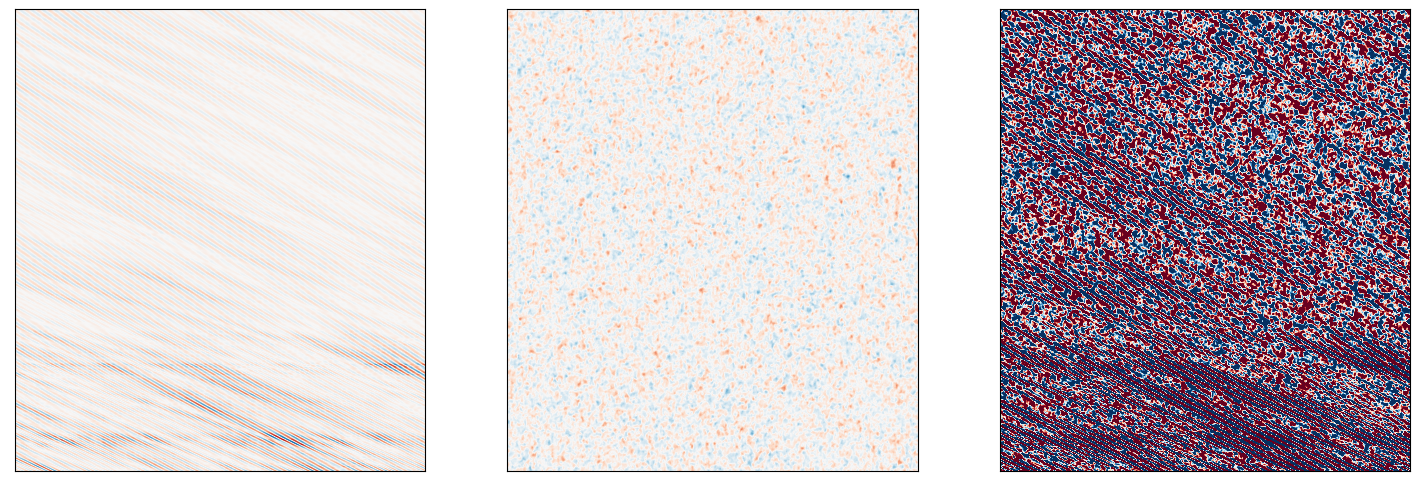

In [13]:
plt.figure(figsize = (18, 6))
plt.subplot(1,3,1)
plt.imshow(TRAIN_DATA, cmap = 'RdBu', aspect = 'auto', origin='lower', 
           vmin = TRAIN_DATA.min(), vmax = TRAIN_DATA.max())
plt.xticks([]); plt.yticks([])
# plt.title("original", fontsize = 20)

plt.subplot(1,3,2)
plt.imshow(predict, cmap = 'RdBu', aspect = 'auto', origin='lower', 
           vmin = TRAIN_DATA.min(), vmax = TRAIN_DATA.max())
plt.xticks([]); plt.yticks([])
# plt.colorbar()
# plt.title("reconstruction", fontsize = 20)

plt.subplot(1,3,3)
plt.imshow(TRAIN_DATA - predict, cmap = 'RdBu', aspect = 'auto', origin='lower', vmin = -0.05, vmax = 0.05)
plt.xticks([]); plt.yticks([])
# plt.colorbar()
# plt.savefig("./figures/rffn_deep.pdf", bbox_inches = 'tight')

## f-k (2D-FFT) transformation 

In [23]:
nnx = TRAIN_DATA.shape[0]
nns = TRAIN_DATA.shape[1]
dx = 2.0419047
dt = 1/20
freq = np.fft.fftshift(np.fft.fftfreq(nns, d=4*dt))
knum = np.fft.fftshift(np.fft.fftfreq(nnx, d=4*dx))

# Calculate the frequency-wavenumber spectrum
ft2_resc = np.fft.fftshift(np.fft.fft2(TRAIN_DATA))
ft2_resc = np.log10(abs(ft2_resc)) # this is not normalized

ft2_orig = np.fft.fftshift(np.fft.fft2(predict))
ft2_orig = np.log10(abs(ft2_orig)) # this is not normalized

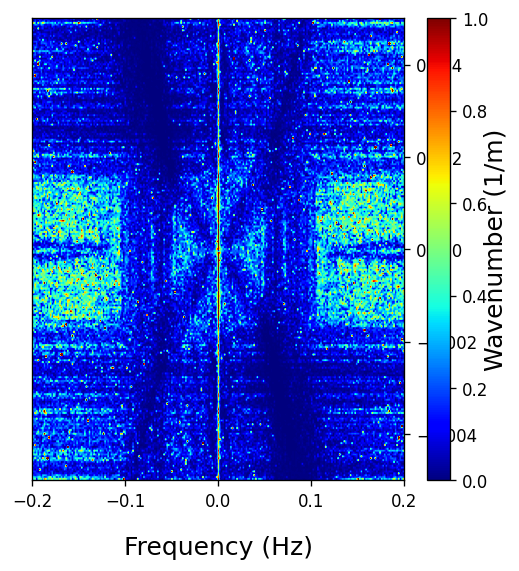

In [32]:
xlim = [-0.2, 0.2]; ylim = [-0.005,0.005]
plt.figure(figsize= (5, 5), dpi = 120)
plt.imshow(np.abs((ft2_orig - ft2_resc)/ft2_orig), cmap='jet', aspect = "auto", 
           extent=[min(freq),max(freq),min(knum),max(knum)], 
           vmin=0,vmax=1)
plt.ylabel("Wavenumber (1/m)", fontsize = 15)
plt.xlabel("Frequency (Hz)", labelpad = 15, fontsize = 15)
# plt.xticks([])
plt.gca().yaxis.tick_right()
plt.gca().yaxis.set_label_position("right")
plt.xlim(xlim)
plt.ylim(ylim)
plt.colorbar()
# plt.savefig("fk1.pdf", bbox_inches = 'tight')